---
# Анализ продаж игр
---

## Описание проекта

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года, нужно спланировать кампанию на 2017-й.  

Примечание: данные за 2016 год неполные.

## 1. Описание данных

+ name — название игры
+ platform — платформа
+ year_of_release — год выпуска
+ genre — жанр игры
+ na_sales — продажи в Северной Америке (миллионы долларов)
+ eu_sales — продажи в Европе (миллионы долларов)
+ jp_sales — продажи в Японии (миллионы долларов)
+ other_sales — продажи в других странах (миллионы долларов)
+ critic_score — оценка критиков (максимум 100)
+ user_score — оценка пользователей (максимум 10)
+ rating — рейтинг от организации ESRB (Entertainment Software Rating Board).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.columns = map(str.lower, games.columns)
games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


+ Пропуски наличествуют в столбцах __name__, __year_of_release__, __genre__, __critic_score__, __user_score__, __rating__.
+ Некорректный тип данных в столбцах __user_score__.

## 2. Подготовка данных

### Обработка пропусков

In [3]:
games[games['name'].isna() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Строки с пропусками в столбце __name__ имеют пропуски и в других столбцах с важной информацией. Удалим их, поскольку восстановить информацию не представляется возможным.

In [4]:
games = games.dropna(subset=['name']).reset_index(drop=True);

In [5]:
games[games['year_of_release'].isna() == True].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Имеем 269 пропусков (~1.6%) в столбце __year_of_release__. Поскольку весь последующий анализ строится на разбивке по годам, эти игры не представляюь для нас интерес, удалим их.

In [6]:
games = games.dropna(subset=['year_of_release']).reset_index(drop=True);

+ Для всех пропусков у нас не достаточно информации для заполнения.
+ Похоже, что пропуски носят случайный характер, ибо не привязаны к конкретной платформе, году выпуска или жанру.
+ Пропуски в столбцах с оценками и рейтингом, вероятно, означают, что для этих игр не были присвоены какие-либо оценки.

### Изменение типов данных

+ tbd - to be determined. Значит данных пока нет, можно заменять на _NaN_.
+ Из-за строк с 'tbd' тип данных в столбце определялся как _object_ , теперь можно привести к _float_.

In [7]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan

In [8]:
games['user_score'] = pd.to_numeric(games['user_score'])

+ Тип данных в столбце __year_of_release__ можно изменить на _int_ оптимизации ради.

In [9]:
games['year_of_release'] = games['year_of_release'].astype('int')

### Подсчёт суммарных продаж игр

Рассчитаем суммарные продажи сложив продажи по отдельным регионам

In [10]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

## 3. Исследовательский анализ данных

##### Количество выпущенных игр с разбивкой по годам

<AxesSubplot:xlabel='year_of_release'>

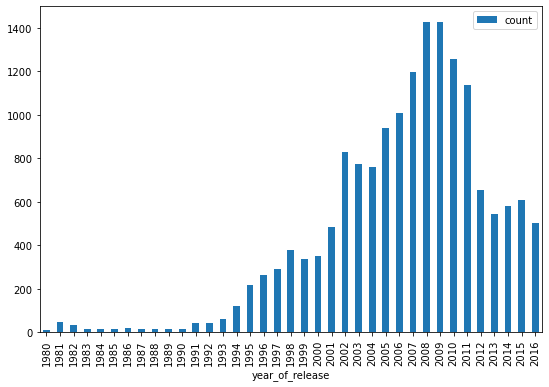

In [11]:
year_count = games.pivot_table(index='year_of_release', values='name', aggfunc=['count'])
year_count.columns = ['count']
year_count.plot(kind='bar', figsize=(9, 6))

+ На заре игровой индустрии выпускалось мало игр и начиная с 1991 года начался быстрый рост их производства с пиком в 2008-2009 годах. Затем наступил спад, продолжавшийся до 2013 года, после которого опять наметился рост выпускаемых игр.
+ Сокращение выпуска игр после 2009 года, вероятно связано с развитием мобильной игровой индустрии.
+ Данные за 80-е, 90-е годы для нас сейчас интереса точно не представляют, поскольку игровые платформы тех времен уже потеряли актуальность (кроме PC конечно).

##### Топ суммарных продаж с разбивкой по платформам

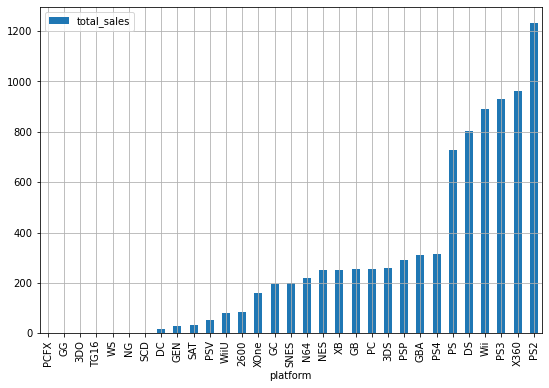

In [12]:
def top_plot(df, column1, column2):
    top_df = df.pivot_table(index=column1, values=column2, aggfunc=['sum'])
    top_df.columns = [column2]
    top_df.sort_values(by=column2).plot(kind='bar', grid=True, figsize=(9, 6))
    
top_plot(games, 'platform', 'total_sales')

Чётко выделяется шестёрка платформ с наибольшими продажами:
1. Sony PlayStation 2
2. Xbox 360
3. Sony PlayStation 3
4. Nintendo Wii
5. Nintendo DS
6. Sony PlayStation


Рассмотрим суммарные продажи по годам для этих платформ

PS



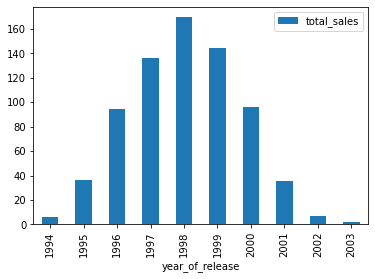

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

DS



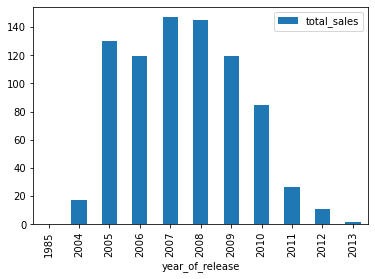

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

Wii



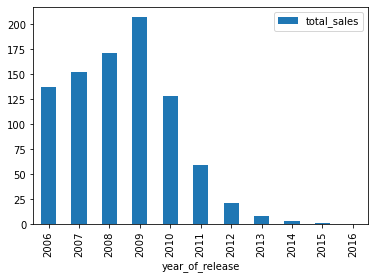

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

PS3



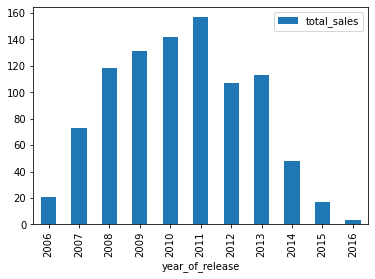

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

X360



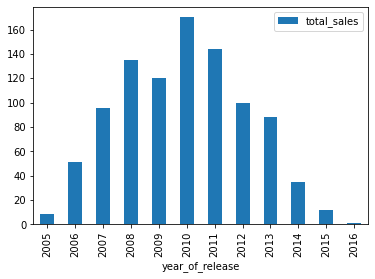

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

PS2



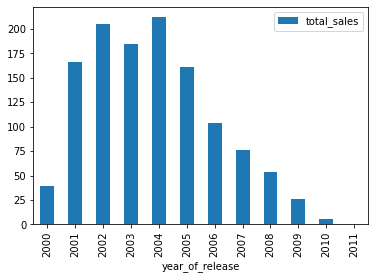

- - - - - - - - - - - - - - - - - - - - - - - - - - - 



In [13]:
platforms_list = ['PS', 'DS', 'Wii', 'PS3', 'X360', 'PS2']

for platform in platforms_list:
    print(platform)
    print()
    sales_by_year = games.query('platform == @platform')
    sales_by_year.groupby('year_of_release').sum().plot(y='total_sales', kind='bar')
    plt.show()
    print('- - - ' * 9)
    print()

По построенным диаграммам видно, что для успешных платформ "время жизни" составляет 9-11 лет. Для прогноза на 2017 год возьмём данные за последние  5 лет, т.е. с 2011 года (актуальный период выбран как половина "времени жизни" платформы).

##### Топ суммарных продаж с разбивкой по платформам (2011-2016гг)

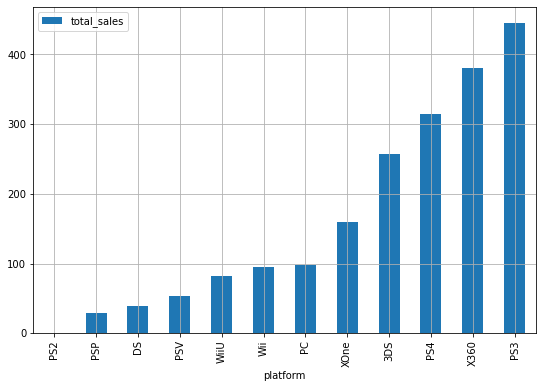

In [14]:
games_last = games.query('year_of_release >= 2011')

top_plot(games_last, 'platform', 'total_sales')

Топ лидеров сменился. Каждому времени свои герои.  

Рассмотрим динамику продаж по годам для каждой платформы.

PS3



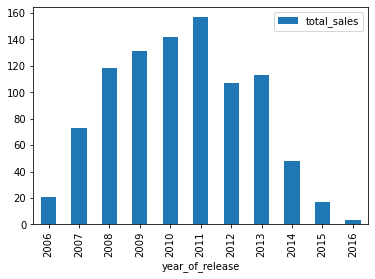

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

X360



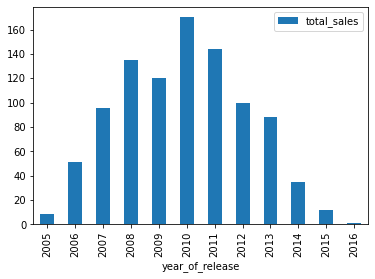

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

PS4



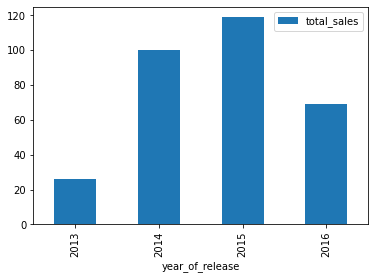

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

3DS



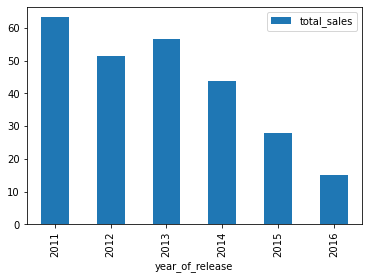

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

Wii



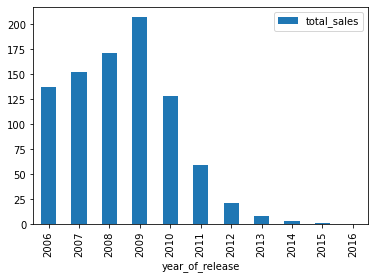

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

DS



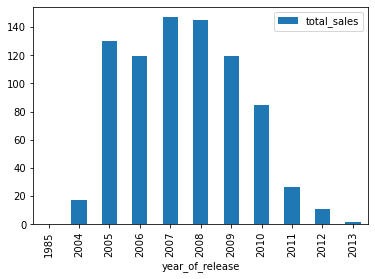

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

XOne



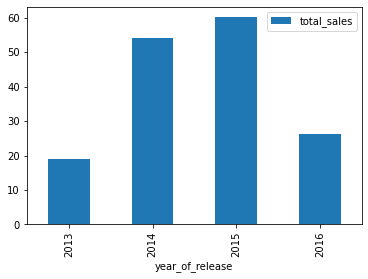

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

WiiU



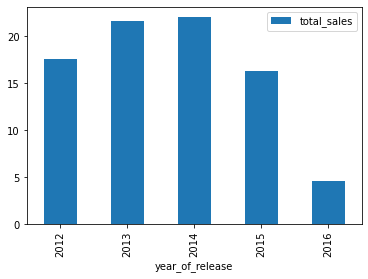

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

PC



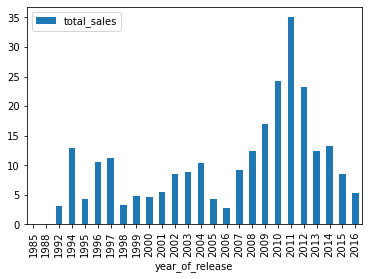

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

PSV



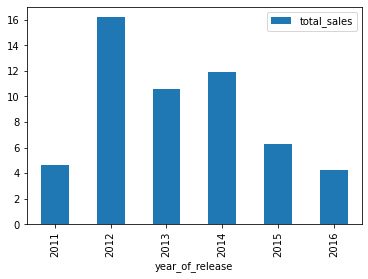

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

PSP



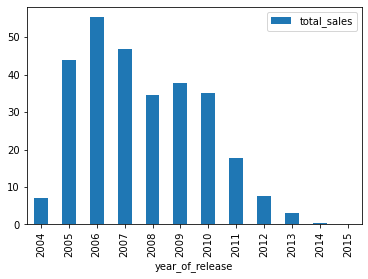

- - - - - - - - - - - - - - - - - - - - - - - - - - - 

PS2



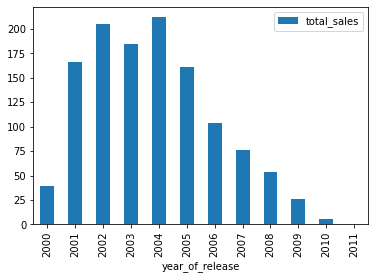

- - - - - - - - - - - - - - - - - - - - - - - - - - - 



In [15]:
platforms_list = games_last['platform'].unique()
for platform in platforms_list:
    print(platform)
    print()
    sales_by_year = games.query('platform == @platform')
    sales_by_year.groupby('year_of_release').sum().plot(y='total_sales', kind='bar')
    plt.show()
    print('- - - ' * 9)
    print()

Из всех платформ к 2016 году в фазе роста находятся лишь две:
+ Sony PlayStation 4
+ Xbox One

В рекламной кампании на них стоит обратить наибольшее внимание.

##### Диаграммы размаха глобальных продаж с разбивкой по платформам

<AxesSubplot:xlabel='platform', ylabel='total_sales'>

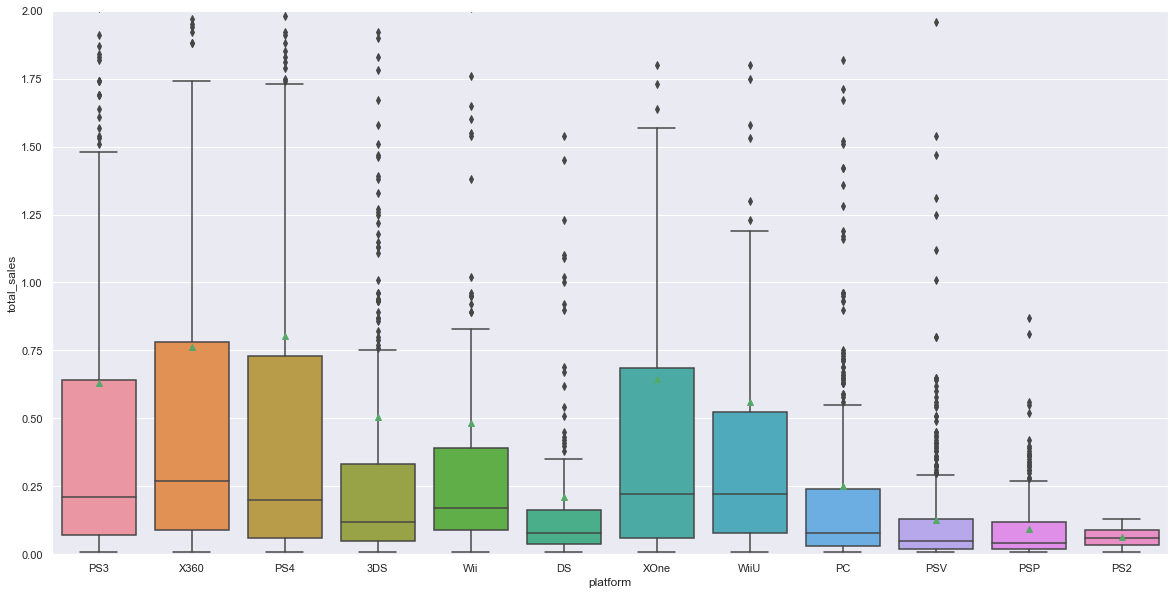

In [27]:
plt.ylim([0, 2])
sns.set(rc={'figure.figsize':(20, 10)})
sns.boxplot(x='platform', y='total_sales', data=games_last, showmeans=True)

+ Медианные продажи для популярных платформ не сильно различаются.
+ Видна сильная скошенность. Обусловлено тем, что имеется ряд наиболее популярных игр с большими продажами.
+ У лидера по глобальным продажам - Sony PlayStation 3 средние продажи ниже, чем у ближайших конкурентов. Можно сделать вывод, что это вызвано большим числом игр, выпущенных на этой платформе.

##### Влияние отзывов на продажи внутри одной платформы

Построим диаграмму рассеяния для Sony PlayStation 3 по которой попытаемся выяснить есть ли зависимость между продажами и отзывами. Выбросы, определённые по диаграмме размаха, учитываться не будут.

Зависимость продаж от отзывов критиков


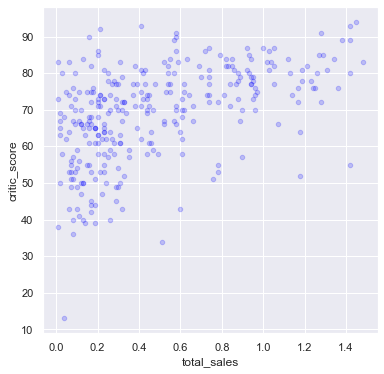

Коэффициент корреляции: 0.50


In [17]:
rating = games_last.query('platform == "PS3" and total_sales < 1.5')
print('Зависимость продаж от отзывов критиков')
rating.plot(x='total_sales', y='critic_score', kind='scatter', c='BLue', figsize=(6, 6), alpha=0.2)
plt.show()
print('Коэффициент корреляции: {:.2f}'.format(rating['critic_score'].corr(rating['total_sales'])))

+ Наблюдается слабая взимосвязь между отзывами критиков и продажами. Видно, что среди игр с высокими оценками доля с высокими продажами больше, чем у игр с низкими оценками.

Зависимость продаж от отзывов пользователей


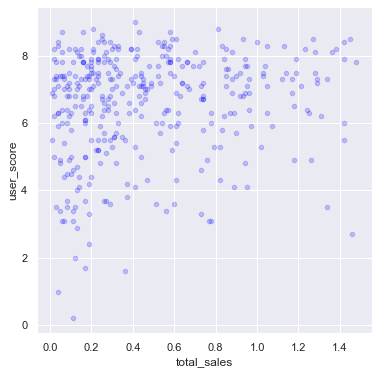

Коэффициент корреляции: 0.15


In [18]:
print('Зависимость продаж от отзывов пользователей')
rating.plot(x='total_sales', y='user_score', kind='scatter', c='BLue', figsize=(6, 6), alpha=0.2)
plt.show()
print('Коэффициент корреляции: {:.2f}'.format(rating['user_score'].corr(rating['total_sales'])))

+ Линейная зависимость между продажами и отзывами пользователей отсутствует.

Для других платформ картина будет аналогичной. В целом можно сказать, что ни оценки критиков, ни оценки пользователей не отражают мнения большинства игроков.

##### Распределение  игр по жанрам

Количество выпущенных игр с разбивкой по жанрам


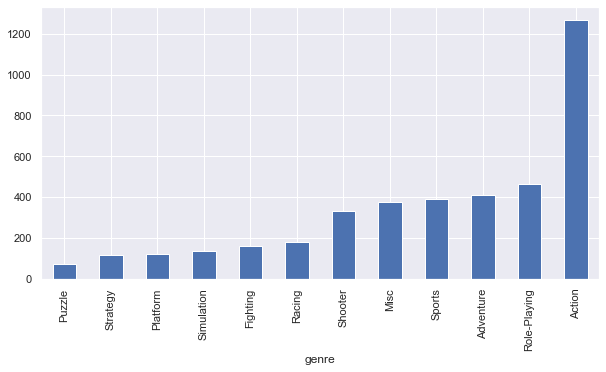

In [19]:
print('Количество выпущенных игр с разбивкой по жанрам')
games_last.groupby('genre')['name'].count().sort_values().plot(kind='bar', figsize=(10, 5));

Глобальные продажи игр с разбивкой по жанрам


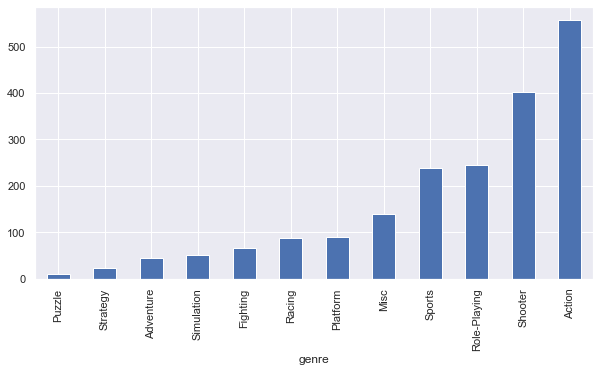

In [20]:
print('Глобальные продажи игр с разбивкой по жанрам')
games_last.groupby('genre')['total_sales'].sum().sort_values().plot(kind='bar', figsize=(10, 5));

+ Распределение на обоих графиках схожее. На лицо основной закон рынка - спрос рождает предложение.
+ Больше всего выпускают игры жанра _Action_ и на них же люди тратят больше денег.
+ Самые низкие продажи у игр жанра _Puzzle_.

## 4. Портрет пользователя по регионам

##### Северная америка

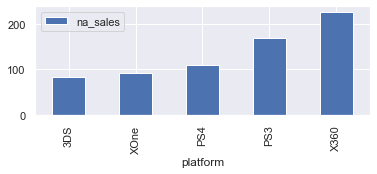

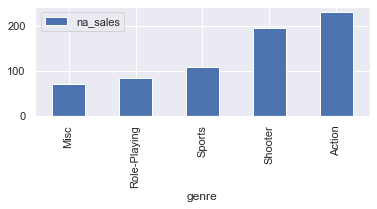

In [21]:
def top5_plot(df, column1, column2):
    top_df = df.pivot_table(index=column1, values=column2, aggfunc=['sum'])
    top_df.columns = [column2]
    top_df.sort_values(by=column2).tail().plot(kind='bar', grid=True, figsize=(6, 2))
    
top5_plot(games_last, 'platform', 'na_sales')
top5_plot(games_last, 'genre', 'na_sales')

##### Европа

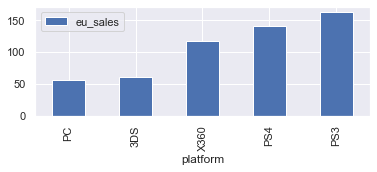

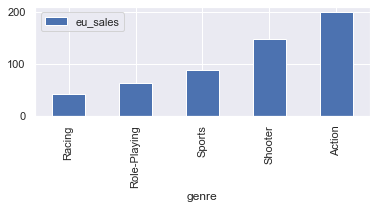

In [22]:
top5_plot(games_last, 'platform', 'eu_sales')
top5_plot(games_last, 'genre', 'eu_sales')

##### Япония

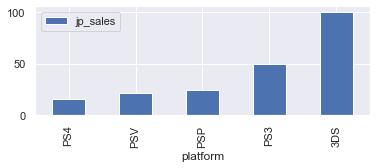

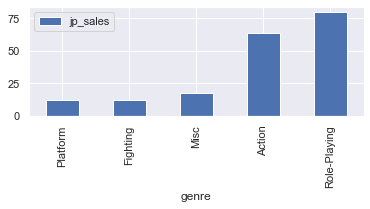

In [23]:
top5_plot(games_last, 'platform', 'jp_sales')
top5_plot(games_last, 'genre', 'jp_sales')

+ В Америке наибольшей популярностью пользуется Xbox 360, также в топе присутствует Xbox One. Обе платформы разработаны компанией Microsoft (базируется в США)
+ В Европе по продажам лидирует Sony PlayStation 3, Xbox 360 занимает 3-е место.
+ В Японии в Топ-5 входят платформы только японских компаний. Первое место занимает Nintendo 3DS - портативная игровая приставка.


+ В Европе и Америке распределение по жанрам практически одинаковое. В топ-3 входят наиболее динамичные жанры.
+ В Японии наиболее популярен жанр ролевых игр.

Различия в предпочитаемых жанрах отражают культурные особенности регионов и различия в менталитете (Европа и Америка близки по духу, поэтому разлчия минимальны).

### Исследование влияния рейтинга ESRB на продажи в отдельном регионе

Entertainment Software Rating Board (ESRB) — негосударственная организация, которая занимается принятием и определением рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.

+ __EC__ (early childhood) - для детей младшего возраста. От 3 лет и старше.
+ __E__ (everyone) - для всех. Возрастная категория от 6 лет и старше.
+ __E10+__ (Everyone 10 and older) - для всех от 10 лет и старше.
+ __T__ (teen) - для подростков. От 13 лет и старше.
+ __M__ (mature) - для взрослых. От 17 лет и старше.
+ __RP__ (rating pending) - рейтинг ожидается.

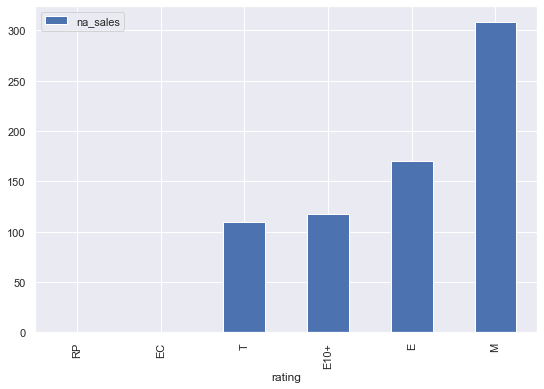

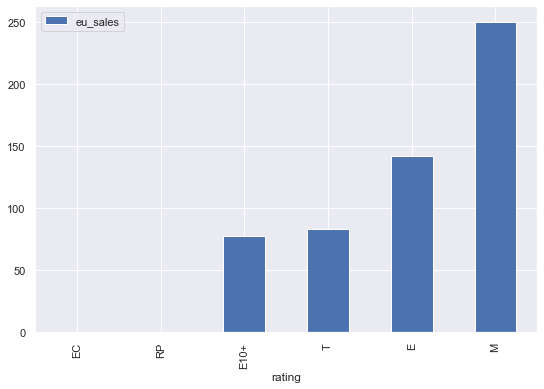

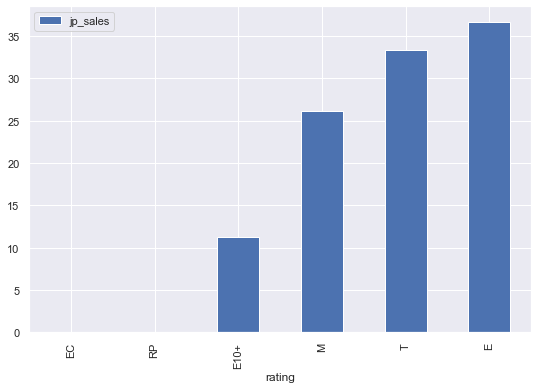

In [24]:
region_sales = ['na_sales', 'eu_sales', 'jp_sales']
for region in region_sales:
    top_plot(games_last, 'rating', region)

Сложно говорить о влиянии рейтинга ESRB по нашим данным. Скорее они отражают предпочтения игроков в разных регионах.

## 5. Проверка гипотез

##### Сравнение средних пользовательских рейтингов платформ Xbox One и PC 

$H_0$ - средние пользовательские рейтинги платформ _Xbox One_ и _PC_ не отличаются  
$H_1$ - рейтинги различаются

In [25]:
user_score_data = games_last.dropna(subset=['user_score'])

print('Средний пользовательский рейтинг платформы Xbox One: {:.2f}'.format(user_score_data[user_score_data['platform'] == 'XOne']['user_score'].mean()))
print('Средний пользовательский рейтинг платформы PC: {:.2f}'.format(user_score_data[user_score_data['platform'] == 'PC']['user_score'].mean()))
print()
alpha = .05
results = st.ttest_ind(
    user_score_data[user_score_data['platform'] == 'XOne']['user_score'],
    user_score_data[user_score_data['platform'] == 'PC']['user_score'],
    equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг платформы Xbox One: 6.52
Средний пользовательский рейтинг платформы PC: 6.45

p-значение: 0.6130712247638477
Не получилось отвергнуть нулевую гипотезу


Средние пользовательские рейтинги платформ Xbox One и PC статистически не отличаются. Оценки ставятся играм, а не платформам.

##### Сравнение средних пользовательских рейтингов жанров Action и Sports

$H_0$ - средние пользовательские рейтинги жанров _Action_ и _Sports_ не отличаются  
$H_1$ - рейтинги различаются

In [26]:
print('Средний пользовательский рейтинг жанра Action: {:.2f}'.format(user_score_data[user_score_data['genre'] == 'Action']['user_score'].mean()))
print('Средний пользовательский рейтинг жанра Sports: {:.2f}'.format(user_score_data[user_score_data['genre'] == 'Sports']['user_score'].mean()))
print()
alpha = .05
results = st.ttest_ind(
    user_score_data[user_score_data['genre'] == 'Action']['user_score'],
    user_score_data[user_score_data['genre'] == 'Sports']['user_score'],
    equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг жанра Action: 6.78
Средний пользовательский рейтинг жанра Sports: 5.65

p-значение: 8.285648549432565e-19
Отвергаем нулевую гипотезу


Средние пользовательские рейтинги жанров _Action_ и _Sports_ статистически различаются. Можно говорить о том, что в целом народ предпочитает жанр _Action_.

## 6. Общий вывод

В ходе исследования были выявлены характерные особенности региональных рынков. Для разных регионов следует делать отличающиеся рекламные кампании, в которых неужно делать упор на платформы и жанры с учётом выявленных особенностей.

1. Северная Америка:
    + Перспективная платформа: Xbox One
    + Популярные жанры: Action, Shooter, Sports
    
2. Европа:
    + Перспективная платформа: Sony PlayStation 4, Xbox One
    + Популярные жанры: Action, Shooter, Sports
    
3. Япония:
    + Перспективная платформа: Sony PlayStation 4
    + Популярные жанры: Role-Playing, Action, Misc